In [3]:
from math import sqrt
import re
import numpy as np
import seaborn as sns
import pandas as pd
%matplotlib inline
from pylab import * 
from itertools import product 
from mltools.perfmeasures import *
import random 


/home/sturm/bin/anaconda3/lib/python3.4/site-packages/matplotlib-1.5.1+1724.g35e2781-py3.4-linux-x86_64.egg/matplotlib/__init__.py:898: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


In [4]:
ls = range(1,5) #length of kmer
ys = [1, 2, 3, 4, 5, 6, 10] #some threshold
region = "data/region25_out/region25"

### Run profile kernel

In [5]:
for l, y in product(ls, ys):
    print(">>> Working on parameters L={0}, Y={1}".format(l, y))
    !profkernel-core -o {region}.idfile -K -L {l} -Y {y} -i /usr/share/fastprofkernel/data/Amino.txt -g /usr/share/fastprofkernel/data/Globals.txt {region}.kernelinput > {region}_L{l}_Y{y}.mat 2> {region}_L{l}_Y{y}.mat.log  

>>> Working on parameters L=1, Y=1
>>> Working on parameters L=1, Y=2
>>> Working on parameters L=1, Y=3
>>> Working on parameters L=1, Y=4
>>> Working on parameters L=1, Y=5
>>> Working on parameters L=1, Y=6
>>> Working on parameters L=1, Y=10
>>> Working on parameters L=2, Y=1
>>> Working on parameters L=2, Y=2
>>> Working on parameters L=2, Y=3
>>> Working on parameters L=2, Y=4
>>> Working on parameters L=2, Y=5
>>> Working on parameters L=2, Y=6
>>> Working on parameters L=2, Y=10
>>> Working on parameters L=3, Y=1
>>> Working on parameters L=3, Y=2
>>> Working on parameters L=3, Y=3
>>> Working on parameters L=3, Y=4
>>> Working on parameters L=3, Y=5
>>> Working on parameters L=3, Y=6
>>> Working on parameters L=3, Y=10
>>> Working on parameters L=4, Y=1
>>> Working on parameters L=4, Y=2
>>> Working on parameters L=4, Y=3
>>> Working on parameters L=4, Y=4
>>> Working on parameters L=4, Y=5
>>> Working on parameters L=4, Y=6
>>> Working on parameters L=4, Y=10


### Adding row/col counts to the matrices

In [6]:
row_count = !wc -l {region}_L{ls[0]}_Y{ys[0]}.mat 
row_count = int(row_count[0].split(" ")[0])
row_count

1098

In [7]:
for l, y in product(ls, ys):
    !echo "{row_count} {row_count}\n$(cat {region}_L{l}_Y{y}.mat)" > {region}_L{l}_Y{y}.2.mat

### Execute weka

In [8]:
for l, y in product(ls, ys):
    print(">>> Working on parameters L={0}, Y={1}".format(l, y))
    !java -Xmx5g -cp bin/wekaTobi.jar:bin/weka.jar: weka.classifiers.meta.CVParameterSelection -p 1 -t {region}.arff -x 5 -S 1 -W weka.classifiers.functions.SMO -- -C 1.0 -L 0.0010 -P 1.0E-12 -N 0 -V -1 -W 1 -K "weka.classifiers.functions.supportVector.CustomPrecomputedKernelMatrixKernelFast -M {region}_L{l}_Y{y}.2.mat" > {region}_L{l}_Y{y}.weka

>>> Working on parameters L=1, Y=1
>>> Working on parameters L=1, Y=2
>>> Working on parameters L=1, Y=3
>>> Working on parameters L=1, Y=4
>>> Working on parameters L=1, Y=5
>>> Working on parameters L=1, Y=6
>>> Working on parameters L=1, Y=10
>>> Working on parameters L=2, Y=1
>>> Working on parameters L=2, Y=2
>>> Working on parameters L=2, Y=3
>>> Working on parameters L=2, Y=4
>>> Working on parameters L=2, Y=5
>>> Working on parameters L=2, Y=6
>>> Working on parameters L=2, Y=10
>>> Working on parameters L=3, Y=1
>>> Working on parameters L=3, Y=2
>>> Working on parameters L=3, Y=3
>>> Working on parameters L=3, Y=4
>>> Working on parameters L=3, Y=5
>>> Working on parameters L=3, Y=6
>>> Working on parameters L=3, Y=10
>>> Working on parameters L=4, Y=1
>>> Working on parameters L=4, Y=2
>>> Working on parameters L=4, Y=3
>>> Working on parameters L=4, Y=4
>>> Working on parameters L=4, Y=5
>>> Working on parameters L=4, Y=6
>>> Working on parameters L=4, Y=10


### extract confusion matrix from WEKA and compute standard error

In [19]:
def extract_confusion_matrix_instances(wekafile):
    """
    return list [(actual, predicted), (actual, predicted), ...]
    """
    dataLine = re.compile(r"\d+")
    instances = []
    with open(wekafile) as f: 
        for line in f.readlines():
            if dataLine.search(line): 
                actual, predicted = line.strip().split()[1:3]
                actual = actual[2:]
                predicted = predicted[2:]
                instances.append((actual, predicted))
    return instances            
                

In [20]:
def randsample(instances, fraction=0.5):
    return random.sample(instances, int(fraction*len(instances)))

In [21]:
def get_confusion_matrix(instances): 
    TP = FN = FP = TN = 0
    for actual, predicted in instances: 
        if actual == "positive":
            if predicted == "positive":
                TP += 1
            elif predicted == "negative":
                FN += 1
            else:
                assert False, "invalid predicted class"
        elif actual == "negative":
            if predicted == "positive":
                FP += 1
            elif predicted == "negative":
                TN += 1
            else:
                assert False, "invalid predicted class"
        else: 
            assert False, "invalid actual class"
    return (TP, FN, FP, TN)

In [22]:
def bootstrap(instances, iterations=1000, fraction=0.5):
    perfs = []
    for i in range(iterations):
        perfs.append(get_confusion_matrix(randsample(instances)))
    return perfs

In [23]:
def stderr(array):
    return np.std(array) / np.sqrt(len(array))

In [48]:
perf_dict = {}
for l, y in product(ls, ys):
    instances = extract_confusion_matrix_instances("{0}_L{1}_Y{2}.weka".format(region, l, y))
    perfs = bootstrap(instances)
    perf_dict[(l, y)] = perfs

In [49]:
perf_dict30 = {}
for l, y in product(ls, ys):
    instances = extract_confusion_matrix_instances("data/region30_out/region30_L{}_Y{}.weka".format(l, y))
    perfs = bootstrap(instances)
    perf_dict30[(l, y)] = perfs

### compare the parameters
#### Which measure to use?
* Accuracy: bad because data is unbalanced
* F-Measure: hard to interpret intuitievely
* MCC: good, easy to interpret and balanced
* Sensistivity, Specificity: good, give the user information about what they actually expect from the predictor

In [50]:
def make_df(f, standard_error = False, perf_dict=perf_dict):
    f_dict = {}
    for y in ys:
        f_dict[y] = {}
        for l in ls:
            perfs = []
            confusion_lines = perf_dict[(l, y)]
            for confusion_line in confusion_lines:
                perfs.append(f(*confusion_line))
            perf = np.mean(perfs)
            if standard_error:
                perf_se = stderr(perfs)
                f_dict[y][l] = (perf, perf_se)
            else: 
                f_dict[y][l] = perf
    return pd.DataFrame(f_dict)

,1,2,3,4,5,6,10
1,0.515116,0.653673,0.699319,0.649084,0.638827,0.639292,0.639865
2,0.197311,0.461638,0.552431,0.585958,0.606381,0.605746,0.657069
3,NaN,0.111180,0.412250,0.468657,0.541184,0.584321,0.670016
4,NaN,NaN,NaN,0.140733,0.341856,0.458765,0.626219


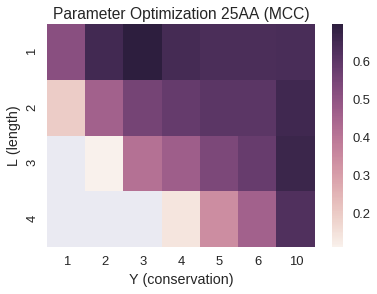

In [30]:
sns.set_context("talk")
fig, ax = subplots(figsize=(6, 4))
sns.heatmap(make_df(mcc))
ax.set_xlabel("Y (conservation)")
ax.set_ylabel("L (length)")
ax.set_title("Parameter Optimization 25AA (MCC)")
fig.savefig("pres/img/mcc25.pdf")
make_df(mcc)

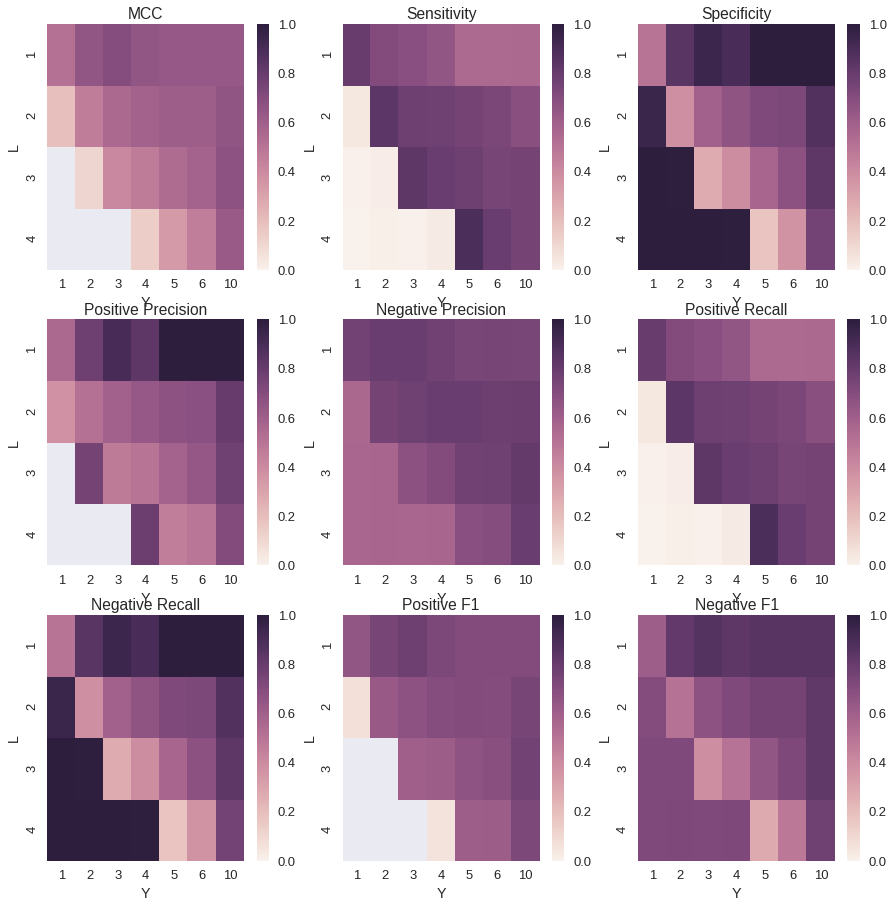

In [27]:
fig, grid = subplots(3, 3, figsize=(15, 15))

sns.heatmap(make_df(mcc), ax=grid[0][0], vmin=0, vmax=1)
grid[0][0].set_title("MCC")

sns.heatmap(make_df(sens), ax=grid[0][1], vmin=0, vmax=1)
grid[0][1].set_title("Sensitivity")

sns.heatmap(make_df(spec), ax=grid[0][2], vmin=0, vmax=1)
grid[0][2].set_title("Specificity")

sns.heatmap(make_df(prec_pos), ax=grid[1][0], vmin=0, vmax=1)
grid[1][0].set_title("Positive Precision")

sns.heatmap(make_df(prec_neg), ax=grid[1][1], vmin=0, vmax=1)
grid[1][1].set_title("Negative Precision")

sns.heatmap(make_df(recall_pos), ax=grid[1][2], vmin=0, vmax=1)
grid[1][2].set_title("Positive Recall")

sns.heatmap(make_df(recall_neg), ax=grid[2][0], vmin=0, vmax=1)
grid[2][0].set_title("Negative Recall")

sns.heatmap(make_df(f1_pos), ax=grid[2][1], vmin=0, vmax=1)
grid[2][1].set_title("Positive F1")

sns.heatmap(make_df(f1_neg), ax=grid[2][2], vmin=0, vmax=1)
grid[2][2].set_title("Negative F1")


for ax in grid.flatten():
    ax.set_xlabel("Y")
    ax.set_ylabel("L")
    
fig.savefig("wiki/eval25.png")

In [51]:
mccdf = make_df(mcc, True)
mccdf30 = make_df(mcc, True, perf_dict30)

In [52]:
sensdf = make_df(sens, True)
sensdf30 = make_df(sens, True, perf_dict30)

In [53]:
specdf = make_df(spec, True)
specdf30 = make_df(spec, True, perf_dict30)

In [54]:
mccdf[3][1]

(0.70015006568485905, 0.00051838483647845528)

In [101]:
dd = {
    "MCC": [mccdf[3][1][0], mccdf30[3][1][0]],
    "Sens.": [sensdf[3][1][0], sensdf30[3][1][0]],
    "Spec.": [specdf[3][1][0], specdf30[3][1][0]]
}
dderr = {
    "MCC": [mccdf[3][1][1], mccdf30[3][1][1]],
    "Sens.": [sensdf[3][1][1], sensdf30[3][1][1]],
    "Spec.": [specdf[3][1][1], specdf30[3][1][1]]
}

In [102]:
df = pd.DataFrame(dd)
dferr = pd.DataFrame(dderr)

In [103]:
df = df.transpose()
dferr = dferr.transpose()

In [104]:
df.columns = ["25aa", "30aa"]
df

,25aa,30aa
MCC,0.700150,0.684635
Sens.,0.685198,0.670502
Spec.,0.943613,0.934023


In [105]:
dferr.columns = ["25aa", "30aa"]
# dferr = dferr * 200
dferr

,25aa,30aa
MCC,0.000518,0.000585
Sens.,0.000689,0.000776
Spec.,0.000298,0.000343


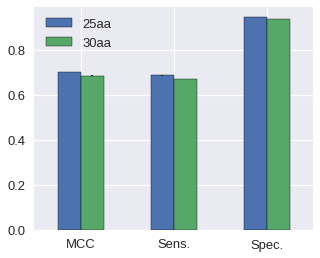

In [107]:
fig, ax = subplots(figsize=(5, 4))
df.plot.bar(ax=ax, yerr=dferr)
ax.set_xticklabels(ax.xaxis.get_majorticklabels(), rotation=0)
fig.savefig("pres/img/perfs_best.pdf")